In [ ]:
!pip3 install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.9 MB 31.5 MB/s 
     |████████████████████████████████| 578.0 MB 17 kB/s 
     |████████████████████████████████| 1.7 MB 51.6 MB/s 
     |████████████████████████████████| 438 kB 75.8 MB/s 
     |████████████████████████████████| 5.9 MB 65.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninst

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.groupby('Category').describe()


Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [7]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [9]:
# 15% spam emails, 85% ham emails: This indicates class imbalance
747/4825

0.15481865284974095

In [14]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [12]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [15]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [16]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [17]:
df_balanced['Category'].value_counts()


ham     747
spam    747
Name: Category, dtype: int64

In [18]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
2638,ham,No I don't have cancer. Moms making a big deal...,0
4752,spam,Your weekly Cool-Mob tones are ready to downlo...,1
1189,ham,All will come alive.better correct any good lo...,0
856,spam,Talk sexy!! Make new friends or fall in love i...,1
4712,ham,Huh so slow i tot u reach long ago liao... U 2...,0


## Split it into training and test data set

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [20]:
X_train.head(4)

2267    <Forwarded from 88877>FREE entry into our £250...
5468    URGENT! Last weekend's draw shows that you hav...
3158            Havent shopping now lor i juz arrive only
505                                               #ERROR!
Name: Message, dtype: object

## Now lets import BERT model and get embeding vectors for few sample statements

In [21]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [22]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.843517  , -0.51327276, -0.88845724, ..., -0.7474888 ,
        -0.75314736,  0.91964495],
       [-0.8720837 , -0.5054399 , -0.9444668 , ..., -0.8584752 ,
        -0.71745354,  0.8808299 ]], dtype=float32)>

## Get embeding vectors for few sample words. Compare them using cosine similarity

In [23]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [24]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

Values near to 1 means they are similar. 0 means they are very different. Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits



In [25]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703875]], dtype=float32)

Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes



In [26]:
cosine_similarity([e[3]],[e[4]])


array([[0.9872035]], dtype=float32)

Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above



Build Model

There are two types of models you can build in tensorflow.

(1) Sequential (2) Functional

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [27]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [29]:
len(X_train)

1120

In [32]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

## Train the model

In [31]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 333s 9s/step - loss: 0.6219 - accuracy: 0.6839 - precision: 0.6794 - recall: 0.6964
Epoch 2/10
35/35 [==============================] - 320s 9s/step - loss: 0.5011 - accuracy: 0.8375 - precision: 0.8399 - recall: 0.8339
Epoch 3/10
35/35 [==============================] - 321s 9s/step - loss: 0.4316 - accuracy: 0.8670 - precision: 0.8612 - recall: 0.8750
Epoch 4/10
35/35 [==============================] - 319s 9s/step - loss: 0.3865 - accuracy: 0.8875 - precision: 0.8903 - recall: 0.8839
Epoch 5/10
35/35 [==============================] - 318s 9s/step - loss: 0.3554 - accuracy: 0.8938 - precision: 0.8959 - recall: 0.8911
Epoch 6/10
35/35 [==============================] - 320s 9s/step - loss: 0.3226 - accuracy: 0.9071 - precision: 0.9101 - recall: 0.9036
Epoch 7/10
35/35 [==============================] - 318s 9s/step - loss: 0.3158 - accuracy: 0.8982 - precision: 0.8872 - recall: 0.9125
Epoch 8/10
35/35 [==============================

In [33]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 107s 9s/step - loss: 0.2807 - accuracy: 0.9251 - precision: 0.9036 - recall: 0.9519


[0.2806932330131531, 0.9251337051391602, 0.903553307056427, 0.9518716335296631]

In [34]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 114s 9s/step


In [35]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,

In [36]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[168,  19],
       [  9, 178]])

Text(33.0, 0.5, 'Truth')

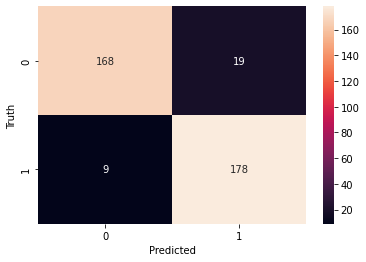

In [37]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [38]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92       187
           1       0.90      0.95      0.93       187

    accuracy                           0.93       374
   macro avg       0.93      0.93      0.93       374
weighted avg       0.93      0.93      0.93       374



Inference

In [39]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 2s 2s/step


array([[0.7432819 ],
       [0.8218609 ],
       [0.7622462 ],
       [0.1856332 ],
       [0.09419487]], dtype=float32)